# AZ by ecosystem clustering

Forest
- kmeans separates xu and liu. 
    - by hamming distance, not clear why, there are otehr products each is similar too. (0.62)
- optics doesn't pull out anything

Grasslands
- kmeans separates nothing
- optics separates out esa and ltgnn 
    - again by similarity not sure why (these are 0.36)

In [2]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation, OPTICS, MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from utils import *

In [1]:
# Load the dataset
biomass_data = pd.read_csv('agb_AZ_final.csv')

#Drop the year column
biomass_data = biomass_data.drop('year', axis=1)

NameError: name 'pd' is not defined

In [3]:
df=biomass_data

# Get unique product categories
unique_products = df['product'].unique()

# Create a dictionary to store separate dataframes
product_dfs = {}

# Separate the dataframe for each unique product
for product in unique_products:
    product_dfs[product] = df[df['product'] == product].copy()
    
    # Reset index for each separated dataframe
    product_dfs[product].reset_index(drop=True, inplace=True)

In [4]:
#Combine agb data for all products into one dataframe, locations on rows, products on cols

# Create an empty dataframe to store the combined 'agb_MG_ha' columns
combined_df = pd.DataFrame()

# Append 'agb_MG_ha' column for each product category into the combined dataframe
for product in unique_products:
    # Extract the 'agb_MG_ha' column for the current product category
    product_agb = product_dfs[product]['agb_Mg_ha'].reset_index(drop=True)
    
    # Rename the column to indicate the product category
    product_agb.name = f'{product}'
    
    # Append the column to the combined dataframe
    combined_df = pd.concat([combined_df, product_agb], axis=1)

In [5]:
# Prep data for clustering

# Remove non-numeric rows
data_transposed_numeric = combined_df.select_dtypes(include=[np.number])

# Replace 'NA' with NaN
data_transposed_numeric = data_transposed_numeric.replace('NA', np.nan)

# Drop rows with all NaN values
data_transposed_numeric = data_transposed_numeric.dropna(axis=1, how='all')

# Impute missing values with column mean
imputer = SimpleImputer(strategy='mean')
# Impute missing values with ROW mean (must use transposed df and axis=1 for rows)
data_imputed = data_transposed_numeric.T.fillna(data_transposed_numeric.mean(axis=1)).T

In [6]:
data_imputed

,chopping,esa,gedi,gfw,harmonized,liu,ltgnn,menlove,natl,xu
0,445.0,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.0,445.00000
1,-9999.0,-9999.000000,-7498.500000,-7498.500000,3.000000,-7498.500000,-9999.000000,-7498.500000,-7498.5,-7498.50000
2,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.00000
3,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.00000
4,0.0,3.227728,6.378667,3.440284,3.440284,9.633644,0.523012,0.000000,0.0,7.75922
...,...,...,...,...,...,...,...,...,...,...
5396,0.0,0.000000,0.352851,1.214329,1.214329,8.560379,0.000000,0.801399,0.0,0.00000
5397,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.00000
5398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5399,780.0,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.0,780.00000


In [7]:
#add back information columns. this df IS NOT used for clustering, just for reference
full_df=pd.concat([data_imputed,product_dfs['chopping']['Latitude']], axis=1)
full_df=pd.concat([full_df,product_dfs['chopping']['Longitude']], axis=1)
full_df=pd.concat([full_df,product_dfs['chopping']['IGBP_Name']], axis=1)
full_df=pd.concat([full_df,product_dfs['chopping']['IGBP_Class']], axis=1)
full_df=pd.concat([full_df,product_dfs['chopping']['ffp_radius']], axis=1)
full_df=full_df.dropna(how='any')
full_df

,chopping,esa,gedi,gfw,harmonized,liu,ltgnn,menlove,natl,xu,Latitude,Longitude,IGBP_Name,IGBP_Class,ffp_radius
0,445.0,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.0,445.000000,36.228055,-118.502698,Evergreen Needleleaf Forest,1,1
1,-9999.0,-9999.000000,-7498.500000,-7498.500000,3.000000,-7498.500000,-9999.000000,-7498.500000,-7498.5,-7498.500000,35.283820,-115.103417,Evergreen Needleleaf Forest,1,1
2,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.000000,36.335968,-117.900180,Evergreen Needleleaf Forest,1,1
3,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,33.620168,-108.709532,Evergreen Needleleaf Forest,1,1
4,0.0,3.227728,6.378667,3.440284,3.440284,9.633644,0.523012,0.000000,0.0,7.759220,32.127377,-112.648381,Evergreen Needleleaf Forest,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5329,11.0,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.000000,40.202836,-121.776079,Barren or Sparsely Vegetated,16,1
5331,0.0,0.000000,1.587128,2.324030,2.324030,2.324030,0.000000,1.356871,0.0,13.324209,31.587814,-109.249101,Barren or Sparsely Vegetated,16,1
5332,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,33.278444,-108.700540,Barren or Sparsely Vegetated,16,1
5333,98.0,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.0,98.000000,38.835943,-121.389388,Barren or Sparsely Vegetated,16,1


In [8]:
unique_ecosys = full_df['IGBP_Name'].unique()
ecosys_counts = full_df['IGBP_Name'].value_counts()
ecosys_counts

Grasslands                            1133
Open Shrublands                        894
Savannas                               381
Woody Savannas                         321
Barren or Sparsely Vegetated           257
Evergreen Broadleaf Forest             184
Deciduous Broadleaf Forest             165
Croplands                              156
Evergreen Needleleaf Forest             94
Urban and Built-up                      83
Permanent Wetlands                      66
Closed Shrublands                       31
Snow and Ice                            24
Cropland/Natural Vegetation Mosaic      19
Deciduous Needleleaf Forest             16
Mixed Forests                           14
Name: IGBP_Name, dtype: int64

# FORESTS

In [9]:
all_forests=['Evergreen Broadleaf Forest','Deciduous Broadleaf Forest','Evergreen Needleleaf Forest','Deciduous Needleleaf Forest','Mixed Forests']
forest_df = full_df[full_df['IGBP_Name'].isin(all_forests)]
indices_to_keep = full_df[full_df['IGBP_Name'].isin(all_forests)].index

In [10]:
mask = data_imputed.index.isin(indices_to_keep)
# Filter rows to keep only those with indices in indices_to_keep
subset_df = data_imputed[mask]
subset_df

,chopping,esa,gedi,gfw,harmonized,liu,ltgnn,menlove,natl,xu
0,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
1,-9999.000000,-9999.000000,-7498.500000,-7498.500000,3.000000,-7498.500000,-9999.000000,-7498.500000,-7498.500000,-7498.500000
2,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
3,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
4,0.000000,3.227728,6.378667,3.440284,3.440284,9.633644,0.523012,0.000000,0.000000,7.759220
...,...,...,...,...,...,...,...,...,...,...
633,0.000000,0.000000,5.928974,3.639828,3.639828,13.219554,0.000000,0.000000,0.000000,9.970099
635,24.999998,24.999998,24.999998,24.999998,24.999998,24.999998,24.999998,24.999998,24.999998,24.999998
636,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
638,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000


In [11]:
#remove any row that has a NaN value (if any one product is NaN at a location, we want to exclude it)
data_imputed_f=subset_df.dropna(how='any')
data_imputed_f

#transpose dataset for clustering
data_transposed_f = data_imputed_f.T
data_transposed_f

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_transposed_f)

## kmeans

In [12]:
# Initialize variables to store the best results for each index
best_n_silhouette = 0
best_silhouette = -1.0

best_n_calinski_harabasz = 0
best_calinski_harabasz = -1.0

best_n_davies_bouldin = 0
best_davies_bouldin = float('inf')

for n_clusters in range(2, 7):  # Start from 2 clusters
    print(f"n_clusters = {n_clusters}")
    
    # kmeans clustering
    cluster = KMeans(n_clusters=n_clusters)
    clusters = cluster.fit_predict(data_scaled)
    
    # Compute evaluation metrics
    silhouette = silhouette_score(data_scaled, clusters)
    calinski_harabasz = calinski_harabasz_score(data_scaled, clusters)
    davies_bouldin = davies_bouldin_score(data_scaled, clusters)
    
    print(f"Silhouette Index: {silhouette:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    
    # Update the best results for Silhouette Index
    if silhouette > best_silhouette:
        best_n_silhouette = n_clusters
        best_silhouette = silhouette
    
    # Update the best results for Calinski-Harabasz Index
    if calinski_harabasz > best_calinski_harabasz:
        best_n_calinski_harabasz = n_clusters
        best_calinski_harabasz = calinski_harabasz
    
    # Update the best results for Davies-Bouldin Index
    if davies_bouldin < best_davies_bouldin:
        best_n_davies_bouldin = n_clusters
        best_davies_bouldin = davies_bouldin
    
    print("---")

print("Best results for each index:")
print(f"Silhouette Index - Optimal n_clusters: {best_n_silhouette}, Best Silhouette Index: {best_silhouette:.4f}")
print(f"Calinski-Harabasz Index - Optimal n_clusters: {best_n_calinski_harabasz}, Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index - Optimal n_clusters: {best_n_davies_bouldin}, Best Davies-Bouldin Index: {best_davies_bouldin:.4f}")

n_clusters = 2
Silhouette Index: 0.3398
Calinski-Harabasz Index: 4.8325
Davies-Bouldin Index: 1.0376
---
n_clusters = 3
Silhouette Index: 0.2837
Calinski-Harabasz Index: 3.8262
Davies-Bouldin Index: 0.4365
---
n_clusters = 4
Silhouette Index: 0.2418
Calinski-Harabasz Index: 4.5037
Davies-Bouldin Index: 0.4222
---
n_clusters = 5
Silhouette Index: 0.0902
Calinski-Harabasz Index: 4.3976
Davies-Bouldin Index: 0.7876
---
n_clusters = 6
Silhouette Index: 0.1063
Calinski-Harabasz Index: 4.5117
Davies-Bouldin Index: 0.6427
---
Best results for each index:
Silhouette Index - Optimal n_clusters: 2, Best Silhouette Index: 0.3398
Calinski-Harabasz Index - Optimal n_clusters: 2, Best Calinski-Harabasz Index: 4.8325
Davies-Bouldin Index - Optimal n_clusters: 4, Best Davies-Bouldin Index: 0.4222


Cluster labels: [0 0 0 0 0 1 0 0 2 1]
Distances between cluster centers:
[[ 0.         21.19119798 19.87233397]
 [21.19119798  0.         32.00607916]
 [19.87233397 32.00607916  0.        ]]

Distances between data points and cluster centers:
Data point 0: [11.61212617 28.65063428 21.30418515]
Data point 1: [ 7.31571843 24.62000953 20.90920499]
Data point 2: [10.64022463 20.76732881 24.57468575]
Data point 3: [ 5.51959515 18.01420145 19.64381788]
Data point 4: [11.53023751 20.81549665 22.0865063 ]
Data point 5: [26.38341856 12.16009185 36.00552933]
Data point 6: [ 9.08101508 24.52552271 22.20124247]
Data point 7: [ 8.76375477 23.4550838  22.95771953]
Data point 8: [19.87233397 32.00607916  0.        ]
Data point 9: [22.31108775 12.16009185 32.37461555]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster 0 contains multiple products, plotting heatmap...
Cluster 1 contains multiple products, plotting heatmap...


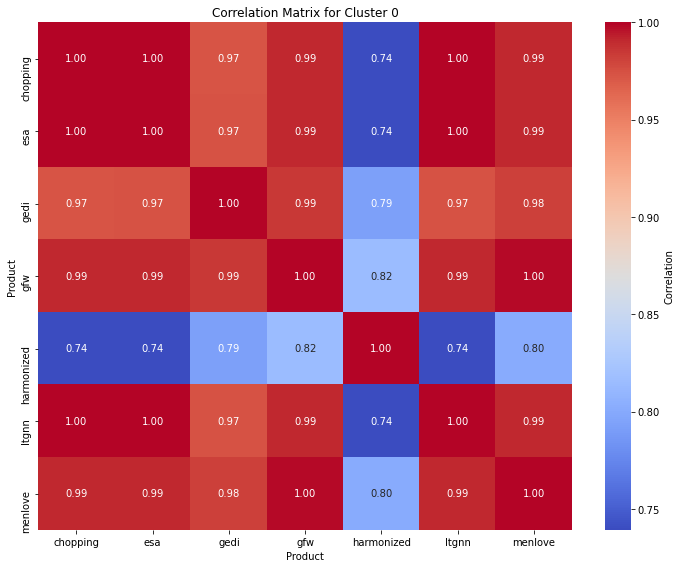

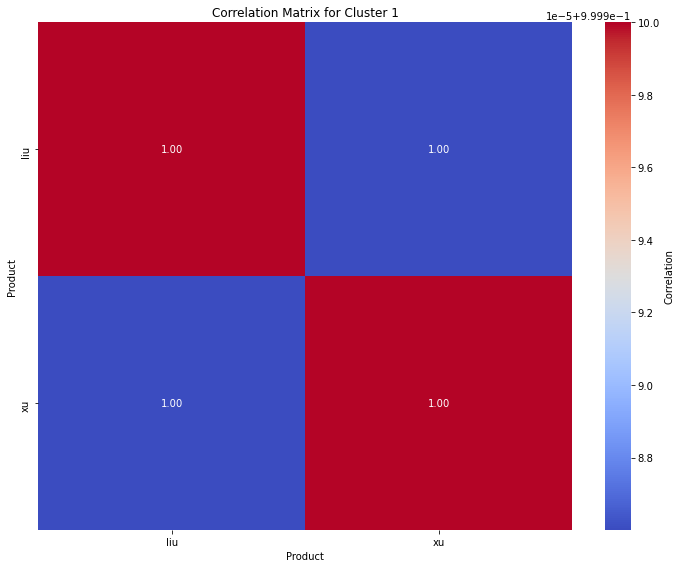

Silhouette Coefficient: 0.258766184901501
Calinski-Harabasz Index: 4.222894935527891
Davies-Bouldin Index: 0.8267302385539897


In [13]:
# kmeans clustering
km = KMeans(n_clusters=3)
clusters = km.fit_predict(data_scaled)
labels = km.labels_
print("Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed_f.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed_f.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']
corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
print_indices(data_scaled, predicted_labels)

## optics

OPTICS Cluster labels: [0 0 0 0 0 0 0 0 0 0]
Distances between cluster centers:
[[0.]]

Distances between data points and cluster centers:
Data point 0: [13.89052955]
Data point 1: [9.56093376]
Data point 2: [10.71900896]
Data point 3: [3.71693155]
Data point 4: [10.83974169]
Data point 5: [23.14026584]
Data point 6: [10.78491232]
Data point 7: [10.27109722]
Data point 8: [19.24353815]
Data point 9: [19.28298642]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster 0 contains multiple products, plotting heatmap...


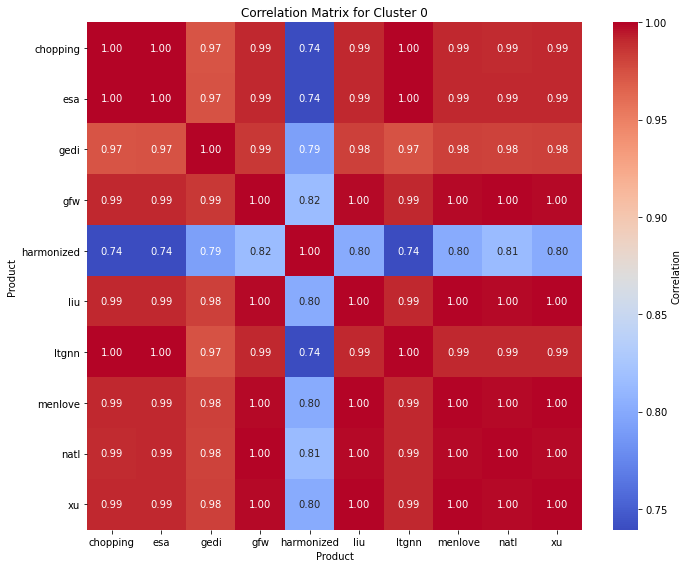

In [14]:
#OPTICS clustering
optics = OPTICS(min_samples=2)
clusters = optics.fit_predict(data_scaled)
labels = optics.labels_
print("OPTICS Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed_f.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed_f.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']

corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
# print_indices(data_scaled, predicted_labels)

## dbscan

In [1]:
# Define the range of values for eps and min_samples
eps_values = np.arange(20, 50, 2)
min_samples_values = range(4, 5)

# Initialize variables to store the best results for each index
best_eps_silhouette = 0
best_min_samples_silhouette = 0
best_silhouette = -1.0

best_eps_calinski_harabasz = 0
best_min_samples_calinski_harabasz = 0
best_calinski_harabasz = -1.0

best_eps_davies_bouldin = 0
best_min_samples_davies_bouldin = 0
best_davies_bouldin = float('inf')

min_samples=2
for eps in eps_values:
#     for min_samples in min_samples_values:
    print(f"eps = {eps:.2f}, min_samples = {min_samples}")

    # DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters_d = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the transposed DataFrame
    data_transposed.loc[:,'cluster'] = clusters_d
    print(clusters_d)

    # Transpose the data back to the original format
    biomass_data_clustered_d = data_imputed.reset_index()

    # Check for noise points
    if -1 in clusters_d:
        print("Noise found during clustering, contained in cluster -1")

    # Compute evaluation metrics
    if len(set(clusters_d)) > 1:  # Check if there are at least two clusters
        silhouette = silhouette_score(data_scaled, clusters_d)
        calinski_harabasz = calinski_harabasz_score(data_scaled, clusters_d)
        davies_bouldin = davies_bouldin_score(data_scaled, clusters_d)

        print(f"Silhouette Index: {silhouette:.4f}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
        print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

        # Update the best results for Silhouette Index
        if silhouette > best_silhouette:
            best_eps_silhouette = eps
            best_min_samples_silhouette = min_samples
            best_silhouette = silhouette

        # Update the best results for Calinski-Harabasz Index
        if calinski_harabasz > best_calinski_harabasz:
            best_eps_calinski_harabasz = eps
            best_min_samples_calinski_harabasz = min_samples
            best_calinski_harabasz = calinski_harabasz

        # Update the best results for Davies-Bouldin Index
        if davies_bouldin < best_davies_bouldin:
            best_eps_davies_bouldin = eps
            best_min_samples_davies_bouldin = min_samples
            best_davies_bouldin = davies_bouldin
    else:
        print("Skipping evaluation metrics as there is only one cluster")

    print("---")

print("Best results for each index:")
print(f"Silhouette Index - Optimal eps: {best_eps_silhouette:.2f}, Optimal min_samples: {best_min_samples_silhouette}, Best Silhouette Index: {best_silhouette:.4f}")
print(f"Calinski-Harabasz Index - Optimal eps: {best_eps_calinski_harabasz:.2f}, Optimal min_samples: {best_min_samples_calinski_harabasz}, Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index - Optimal eps: {best_eps_davies_bouldin:.2f}, Optimal min_samples: {best_min_samples_davies_bouldin}, Best Davies-Bouldin Index: {best_davies_bouldin:.4f}")

NameError: name 'np' is not defined

# GRASSLANDS AND OPEN SHRUBLANDS

In [22]:
gra_osh=['Grasslands','Open Shrublands']
grass_df = full_df[full_df['IGBP_Name'].isin(gra_osh)]
indices_to_keep = full_df[full_df['IGBP_Name'].isin(gra_osh)].index

mask_gra = data_imputed.index.isin(indices_to_keep)
# Filter rows to keep only those with indices in indices_to_keep
subset_df_gra = data_imputed[mask_gra]

#remove any row that has a NaN value (if any one product is NaN at a location, we want to exclude it)
data_imputed_gra=subset_df_gra.dropna(how='any')
data_imputed_gra

#transpose dataset for clustering
data_transposed_gra = data_imputed_gra.T
data_transposed_gra

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_transposed_gra)

In [23]:
# Initialize variables to store the best results for each index
best_n_silhouette = 0
best_silhouette = -1.0

best_n_calinski_harabasz = 0
best_calinski_harabasz = -1.0

best_n_davies_bouldin = 0
best_davies_bouldin = float('inf')

for n_clusters in range(2, 7):  # Start from 2 clusters
    print(f"n_clusters = {n_clusters}")
    
    # kmeans clustering
    cluster = KMeans(n_clusters=n_clusters)
    clusters = cluster.fit_predict(data_scaled)
    
    # Compute evaluation metrics
    silhouette = silhouette_score(data_scaled, clusters)
    calinski_harabasz = calinski_harabasz_score(data_scaled, clusters)
    davies_bouldin = davies_bouldin_score(data_scaled, clusters)
    
    print(f"Silhouette Index: {silhouette:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    
    # Update the best results for Silhouette Index
    if silhouette > best_silhouette:
        best_n_silhouette = n_clusters
        best_silhouette = silhouette
    
    # Update the best results for Calinski-Harabasz Index
    if calinski_harabasz > best_calinski_harabasz:
        best_n_calinski_harabasz = n_clusters
        best_calinski_harabasz = calinski_harabasz
    
    # Update the best results for Davies-Bouldin Index
    if davies_bouldin < best_davies_bouldin:
        best_n_davies_bouldin = n_clusters
        best_davies_bouldin = davies_bouldin
    
    print("---")

print("Best results for each index:")
print(f"Silhouette Index - Optimal n_clusters: {best_n_silhouette}, Best Silhouette Index: {best_silhouette:.4f}")
print(f"Calinski-Harabasz Index - Optimal n_clusters: {best_n_calinski_harabasz}, Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index - Optimal n_clusters: {best_n_davies_bouldin}, Best Davies-Bouldin Index: {best_davies_bouldin:.4f}")

n_clusters = 2
Silhouette Index: 0.3664
Calinski-Harabasz Index: 5.5810
Davies-Bouldin Index: 0.9866
---
n_clusters = 3
Silhouette Index: 0.2854
Calinski-Harabasz Index: 4.4724
Davies-Bouldin Index: 0.4224
---
n_clusters = 4
Silhouette Index: 0.2249
Calinski-Harabasz Index: 4.8299
Davies-Bouldin Index: 0.4294
---
n_clusters = 5
Silhouette Index: 0.0952
Calinski-Harabasz Index: 4.8046
Davies-Bouldin Index: 0.8163
---
n_clusters = 6
Silhouette Index: 0.0851
Calinski-Harabasz Index: 4.6532
Davies-Bouldin Index: 0.7167
---
Best results for each index:
Silhouette Index - Optimal n_clusters: 2, Best Silhouette Index: 0.3664
Calinski-Harabasz Index - Optimal n_clusters: 2, Best Calinski-Harabasz Index: 5.5810
Davies-Bouldin Index - Optimal n_clusters: 3, Best Davies-Bouldin Index: 0.4224


Cluster labels: [0 0 0 0 0 2 0 0 0 1]
Distances between cluster centers:
[[ 0.         45.17524281 59.61840608]
 [45.17524281  0.         50.29664002]
 [59.61840608 50.29664002  0.        ]]

Distances between data points and cluster centers:
Data point 0: [20.72905338 56.69240141 69.62595008]
Data point 1: [16.72429597 50.46791905 65.1741616 ]
Data point 2: [23.79919004 45.7768505  59.09591579]
Data point 3: [12.64412345 38.426693   51.89202998]
Data point 4: [22.24533942 43.32118718 55.10123443]
Data point 5: [59.61840608 50.29664002  0.        ]
Data point 6: [17.09508569 50.0705726  64.50216918]
Data point 7: [19.99547399 49.8609508  62.48085866]
Data point 8: [32.83766406 61.84050335 75.85938411]
Data point 9: [45.17524281  0.         50.29664002]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster 0 contains multiple products, plotting heatmap...


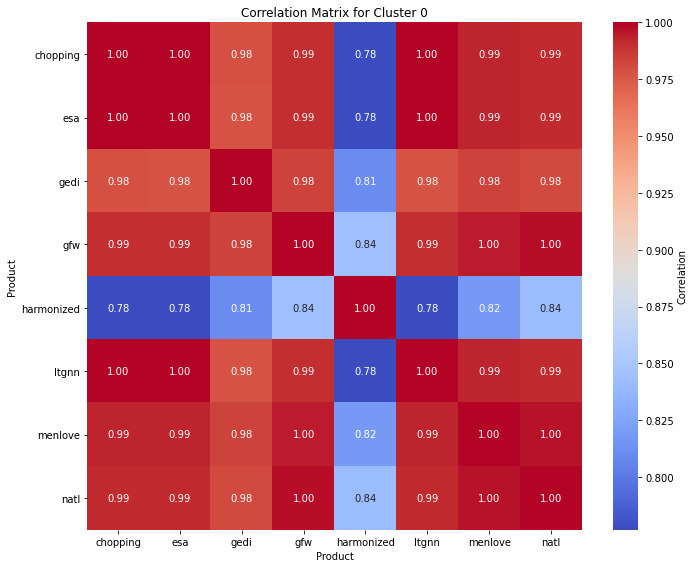

Silhouette Coefficient: 0.2854347864360994
Calinski-Harabasz Index: 4.472386656728625
Davies-Bouldin Index: 0.422409168603812


In [24]:
# kmeans clustering
km = KMeans(n_clusters=3)
clusters = km.fit_predict(data_scaled)
labels = km.labels_
print("Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed_gra.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed_gra.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']
corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
print_indices(data_scaled, predicted_labels)

OPTICS Cluster labels: [-1  0 -1 -1 -1 -1  0 -1 -1 -1]
Distances between cluster centers:
[[ 0.         24.20240771]
 [24.20240771  0.        ]]

Distances between data points and cluster centers:
Data point 0: [26.006199   28.18424981]
Data point 1: [ 7.3550709  25.32837934]
Data point 2: [31.59159708 23.26776366]
Data point 3: [21.71523019  9.4431964 ]
Data point 4: [31.73690546 19.57472765]
Data point 5: [64.42052093 48.57042496]
Data point 6: [ 7.3550709  25.26223295]
Data point 7: [26.55034695 23.41685249]
Data point 8: [39.87041525 37.47365937]
Data point 9: [49.72865853 35.56403253]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster -1 contains multiple products, plotting heatmap...
Cluster 0 contains multiple products, plotting heatmap...


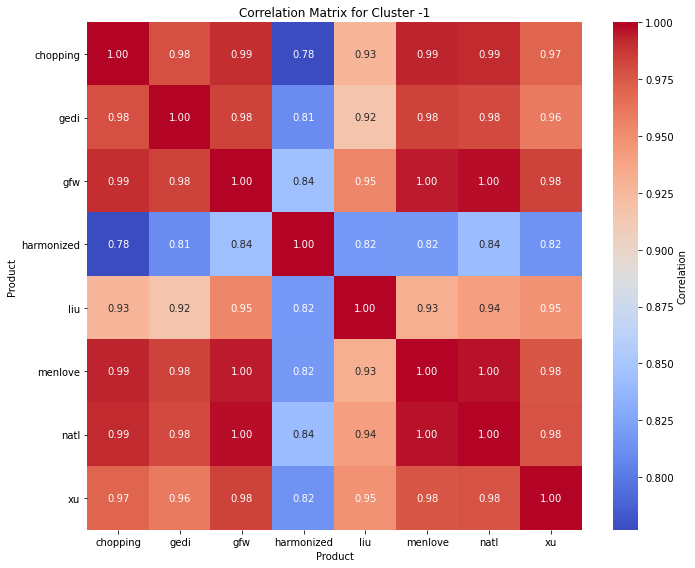

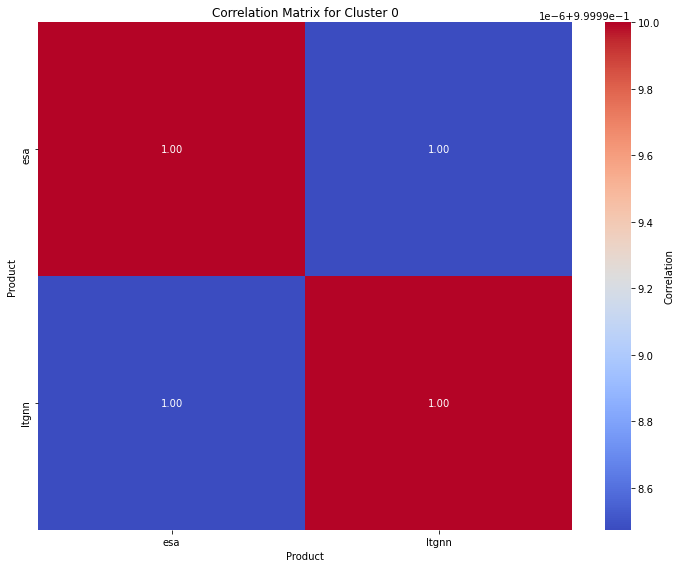

Silhouette Coefficient: -0.014517710149083471
Calinski-Harabasz Index: 1.0006531828442589
Davies-Bouldin Index: 1.468528862159193


In [25]:
#OPTICS clustering
optics = OPTICS(min_samples=2)
clusters = optics.fit_predict(data_scaled)
labels = optics.labels_
print("OPTICS Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed_gra.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed_gra.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']

corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
print_indices(data_scaled, predicted_labels)